In [1]:
%cd /home/maximilianheil/fungiclef-2024/

/home/maximilianheil/fungiclef-2024


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pyspark.sql.functions as f
import pyspark.ml as ml
from pyspark.sql.types import ArrayType, FloatType, IntegerType
import fungiclef.transforms as trans
from fungiclef.utils import get_spark

In [4]:
spark = get_spark(**{
    "spark.sql.parquet.enableVectorizedReader": False, 
})
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/06 20:03:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/06 20:03:30 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [1]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-fungiclef-2024"
! date


! gcloud storage du --readable-sizes {root}/data/parquet/DF20


Sat Apr  6 19:41:43 UTC 2024
0B           gs://dsgt-clef-fungiclef-2024/data/parquet/DF20/
0B           gs://dsgt-clef-fungiclef-2024/data/parquet/DF20/_SUCCESS
576.12MiB    gs://dsgt-clef-fungiclef-2024/data/parquet/DF20/part-00000-cc0df3a9-c0ff-4f41-a2cb-442f4aae0f0c-c000.snappy.parquet
538.03MiB    gs://dsgt-clef-fungiclef-2024/data/parquet/DF20/part-00001-cc0df3a9-c0ff-4f41-a2cb-442f4aae0f0c-c000.snappy.parquet
534.57MiB    gs://dsgt-clef-fungiclef-2024/data/parquet/DF20/part-00002-cc0df3a9-c0ff-4f41-a2cb-442f4aae0f0c-c000.snappy.parquet
577.75MiB    gs://dsgt-clef-fungiclef-2024/data/parquet/DF20/part-00003-cc0df3a9-c0ff-4f41-a2cb-442f4aae0f0c-c000.snappy.parquet
572.16MiB    gs://dsgt-clef-fungiclef-2024/data/parquet/DF20/part-00004-cc0df3a9-c0ff-4f41-a2cb-442f4aae0f0c-c000.snappy.parquet
556.37MiB    gs://dsgt-clef-fungiclef-2024/data/parquet/DF20/part-00005-cc0df3a9-c0ff-4f41-a2cb-442f4aae0f0c-c000.snappy.parquet
589.96MiB    gs://dsgt-clef-fungiclef-2024/data/parquet/DF20/part

In [5]:

gcs_parquet_path = "gs://dsgt-clef-fungiclef-2024/dev/train/"
input_folder = f"dev_train.parquet"

gcs_parquet_path = "gs://dsgt-clef-fungiclef-2024/data/parquet/"
input_folder = f"DF20"



dev_df = spark.read.parquet(gcs_parquet_path+input_folder)
#dev_df = dev_df.repartition('im_bytes')
dev_df.printSchema()
dev_df.count()

root
 |-- image_path: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- observationID: long (nullable = true)
 |-- year: double (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- countryCode: string (nullable = true)
 |-- locality: string (nullable = true)
 |-- taxonID: double (nullable = true)
 |-- scientificName: string (nullable = true)
 |-- kingdom: string (nullable = true)
 |-- phylum: string (nullable = true)
 |-- class: string (nullable = true)
 |-- order: string (nullable = true)
 |-- family: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- specificEpithet: string (nullable = true)
 |-- taxonRank: string (nullable = true)
 |-- species: string (nullable = true)
 |-- level0Gid: string (nullable = true)
 |-- level0Name: string (nullable = true)
 |-- level1Gid: string (nullable = true)
 |-- level1Name: string (nullable = true)
 |-- level2Gid: string (nullable = true)
 |-- level2Name: string (nullable = tr

295938

In [6]:
# Get subset of images to test pipeline
dev_subset_df = (
    dev_df
    #.select("ImageUniqueID", "species", "data")
    #.sample(fraction=0.00011, seed=42)
    .limit(100) # 3 obs
    .cache()
)
print(dev_subset_df.count())

24/04/06 20:04:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


100


In [8]:
# Init DINOv2 wrapper
dino = trans.WrappedDinoV2(input_col="data", output_col="transformed_data")

# Init Descrite Cosine Transform wrapper
dctn = trans.DCTN(input_col="transformed_data", output_col="dctn_data")

# Create Pipeline
pipeline = ml.Pipeline(stages=[dino, dctn]) #, dctn

# Fit pipeline to DF
model = pipeline.fit(dev_subset_df)

# Apply the model to transform the DF
transformed_df = model.transform(dev_subset_df).cache()

# Show results
transformed_df.select(["ImageUniqueID", "species", "transformed_data"]).show(n=10)

+-----------------+--------------------+--------------------+
|    ImageUniqueID|             species|    transformed_data|
+-----------------+--------------------+--------------------+
|2237852555-148572|  Phellinus pomaceus|[3.1817272, 2.699...|
| 2237852674-74828|     Xylodon sambuci|[-0.19241063, 0.6...|
|2237852822-298071|Trichoderma europ...|[-0.6569905, -0.3...|
| 2237852854-74853|   Fomes fomentarius|[1.5465826, 0.821...|
|   2237852973-255|    Trametes hirsuta|[0.5168251, 2.873...|
|2237853507-298195|Phlebiopsis gigantea|[-0.103396, -1.35...|
| 2237853529-74983|     Russula solaris|[1.7673886, -0.41...|
|   2237853748-432|   Peziza vesiculosa|[-2.1228156, 1.08...|
|2237854121-223129|Sarcoscypha austr...|[-3.4140556, 1.35...|
|2237854530-149021| Meripilus giganteus|[1.690781, 1.3716...|
+-----------------+--------------------+--------------------+
only showing top 10 rows



In [10]:
image = dev_subset_df.collect()[0].im_bytes

AttributeError: im_height

In [12]:
import io
from PIL import Image

Image.open(io.BytesIO(image))

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f325d604a90>

In [13]:
from imageio.v3 import imread

imread(io.BytesIO(image))

OSError: Could not find a backend to open `<_io.BytesIO object at 0x7f325ce2bf10>`` with iomode `r`.

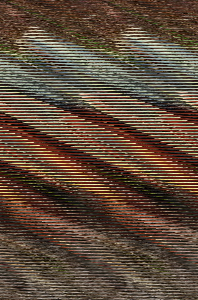

In [45]:
Image.frombytes('RGB', (height,width), image)
